In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy as sp
import quandl
import functools
import seaborn as sns
import plotnine as p9
import math
import datetime
import statsmodels.formula.api as sm
import statsmodels
import statsmodels.api as smapi
from statsmodels.regression.rolling import RollingOLS
import hmmlearn
from hmmlearn.hmm import GaussianHMM
import warnings
import os
import matplotlib.dates as mdates

warnings.filterwarnings('ignore')


from sklearn.linear_model import HuberRegressor, LinearRegression

try:
    # Do not recreate if it already exists
    fetch_quandl
    print("fetch_quandl already defined")
except NameError:
    @functools.lru_cache(maxsize=1000)
    def fetch_quandl(my_securities, trim_start = None, trim_end = None):
        qdata = quandl.get(my_securities, returns="pandas", trim_start = trim_start, trim_end=trim_end,
                          api_key= 'wxaZyBzU1ujzJmnkvA68')
        return qdata
    print("fetch_quandl has now been newly defined")

fetch_quandl has now been newly defined


In [2]:

def fetch_ticker_eod(ticker_list,trim_start,trim_end):
    eod_data = pd.DataFrame()
    for i in ticker_list:
        try:
            eodi = fetch_quandl('EOD/' + i ,trim_start=trim_start, trim_end=trim_end,)
            eodi['ticker'] = i
            eod_data = pd.concat([eod_data,eodi],axis = 0) #verticly combine
        except:
            print(i)
                #do nothing
    return eod_data

In [3]:
def clean_df(df):
    df.columns = ['code', 'time', 'open', 'high', 'low', 'close', 'volume', 'turnover', 'open interest']
    df.rename_axis("type", axis='index', inplace=True)
    df['time'] = pd.to_datetime(df['time'])
    df.reset_index(inplace=True)
    return df

def prepare_data(df):
    prices = df[['close']]
    prices['volume'] = df['volume']
    prices['log_close'] = np.log(prices['close'])
    prices['time'] = df['time']

    prices['lr_5min'] = (prices['log_close'] - prices['log_close'].shift(5))/5
    prices['lr_30min'] = (prices['log_close'] - prices['log_close'].shift(30)) /30

    prices['fast_ma'] = prices['close'].ewm(halflife=5, adjust=False).mean()
    prices['slow_ma'] = prices['close'].ewm(halflife=15, adjust=False).mean()
    prices['macd'] = prices['fast_ma'] - prices['slow_ma']
    prices = prices.dropna(axis = 0)
    return prices


def train_model(prices, n):
    hmm = GaussianHMM(n_components = n)
    hmm.fit(prices[['lr_5min','lr_30min','macd']])
    return hmm

def fit_model(hmm,prices):
    hidden_states = hmm.predict(prices[['lr_5min','lr_30min','macd']])
    return hidden_states

def calculate_state_returns(prices,state,hidden_states):
    temp = prices.copy()
    temp['hidden_state'] = pd.Series(hidden_states)
    returns = []
    temp['hidden_state'] = pd.Series(hidden_states)
    for i in range(30,prices.shape[0] - 30):
        if temp['hidden_state'][i] == state:
            returns.append(prices['close'][i + 30]/prices['close'][i])
    return (returns,len(returns))

def pick_bull_bear(prices,hidden_states,n_states):
    best_sharpe = 0
    worst_sharpe = 100
    worst_index = 420
    best_index = 69
    for i in range(0,n_states):
        state_returns = calculate_state_returns(prices,i,hidden_states)
        avg_return = pd.Series(state_returns[0]).mean()
        varience = pd.Series(state_returns[0]).var()
        sharpe = (avg_return -1)/(varience ** 0.5)
        if(sharpe > best_sharpe):
            best_index = i
            best_sharpe = sharpe
        if(sharpe < worst_sharpe):
            worst_index = i
            worst_sharpe = sharpe
    return (best_index,worst_index)

def plot_hidden_states(prices,hidden_states,nstates,title,bullstate = -1,bearstate = -1):
    legend = []
    plt.figure(figsize=(15,10))
    tempdf = prices
    tempdf['hidden_state'] = pd.Series(hidden_states)
    for i in range(0,nstates):
        if(i == bullstate):
            legend.append('bullish hidden state')
            color = 'green'
        elif i == bearstate:
            legend.append('bearish hidden state')
            color = 'red'
        else:
            legend.append("hidden state" + str(i))
            color = 'grey'
            
        temp = tempdf[tempdf['hidden_state'] == i]
        plt.scatter(temp['time'],temp['close'], s = 10,c = color)
    plt.legend(legend, loc ="upper left")
    plt.xlabel("Time")
    plt.ylabel("Commodity Price")
    plt.title(title)

    plt.show()

In [4]:
def commodity_helper(hmm,bullstate,bearstate,prices,participation_rate):
    returns = []
    for i in prices.index[30:-30]:
        hidden_states = fit_model(hmm,prices[i-30:i])
        if hidden_states[-1] == bullstate:
            tradevol = 1 #so we will have amt that $1 trades will make, then can mult by K  
            ret = (prices['close'][i + 30]/prices['close'][i] -1) * tradevol
            cost = 0.0345 * 0.01 #http://www.cffex.com.cn/en_new/NoticesGuidelinesandOther/20190419/24911.html
            returns.append(ret - cost)
        else:
            returns.append(0)
#         if hidden_states[-1] == bearstate:
#             returns.append((prices['close'][i]/prices['close'][i + 30]) -1)
    return returns 


#give commodity in string form
def run_commodity_strategy(commodity,nstates): 
    df2018 = pd.read_csv('./data/2018/' + commodity + '.csv', index_col=0, encoding='gbk')
    df2019 = pd.read_csv('./data/2019/' + commodity + '.csv', index_col=0, encoding='gbk')
    df2020 = pd.read_csv('./data/2020/' + commodity + '.csv', index_col=0, encoding='gbk')
    df18 = prepare_data(clean_df(df2018))
    df19 = prepare_data(clean_df(df2019))
    df20 = prepare_data(clean_df(df2020))
    
    hmm18 = train_model(df18,nstates)
    hmm19 = train_model(df19,nstates)
    
    hidden_states18 = fit_model(hmm18,df18)
    hidden_states19 = fit_model(hmm19,df19)
    
    states18 = pick_bull_bear(df18,hidden_states18,nstates)
    states19 = pick_bull_bear(df19,hidden_states19,nstates)
    print("bull_bear completed 2018 bull",states18[0],'2018 bear',states18[1])
    print("bull_bear completed 2019 bull",states19[0],'2019 bear',states19[1])

    returns19 = commodity_helper(hmm18,states18[0],states18[1],df19,0.01)
    ret19 = pd.Series(returns19)
    print(commodity + '2019 mean returns trained on 2018 data:',ret19.mean(),'cumulative:',ret19.sum())
    returns20 = commodity_helper(hmm19,states19[0],states19[1],df20,0.01)
    ret20 = pd.Series(returns20)

    print(commodity + '2020 mean returns trained on 2019 data:',ret20.mean(),'cumulative:',ret20.sum())

    return (returns19,returns20)
    
    

    
    


In [5]:
def run_commodity_strategy_daily(commodity, nstates):
    
    df2018 = pd.read_csv('./data/2018/' + commodity + '.csv', index_col=0, encoding='gbk')
    df2019 = pd.read_csv('./data/2019/' + commodity + '.csv', index_col=0, encoding='gbk')
    df2020 = pd.read_csv('./data/2020/' + commodity + '.csv', index_col=0, encoding='gbk')
    
    df18 = prepare_data(clean_df(df2018))
    df18['close'] = df18.resample('D', on='time').last()
    df18['close'] = df18['close'].pct_change()
    
    df19 = prepare_data(clean_df(df2019))
    df19['close'] = df19.resample('D', on='time').last()
    df19['close'] = df19['close'].pct_change()
    
    df20 = prepare_data(clean_df(df2020))
    df20['close'] = df20.resample('D', on='time').last()
    df20['close'] = df20['close'].pct_change()
    
    
    
    hmm18 = train_model(df18,nstates)
    hmm19 = train_model(df19,nstates)
    
    hidden_states18 = fit_model(hmm18,df18)
    hidden_states19 = fit_model(hmm19,df19)
    
    states18 = pick_bull_bear(df18,hidden_states18,nstates)
    states19 = pick_bull_bear(df19,hidden_states19,nstates)
    print("bull_bear completed 2018 bull",states18[0],'2018 bear',states18[1])
    print("bull_bear completed 2019 bull",states19[0],'2019 bear',states19[1])

    returns19 = commodity_helper(hmm18,states18[0],states18[1],df19,0.01)
    ret19 = pd.Series(returns19)
    print(commodity + '2019 mean returns trained on 2018 data:',ret19.mean(),'cumulative:',ret19.sum())
    returns20 = commodity_helper(hmm19,states19[0],states19[1],df20,0.01)
    ret20 = pd.Series(returns20)

    print(commodity + '2020 mean returns trained on 2019 data:',ret20.mean(),'cumulative:',ret20.sum())

    return (returns19,returns20)

In [6]:
commodities = [('agm','Silver'),('cfm','cotton'),('hcm','Hot Rolled Steel'),('jmm','Coal'),
               ('nim','Nickel'),('ppm',"Polypropylene"),('smm',"Manganese Silicon Alloy"),
               ('alm','Aluminum'),('cum','Copper'),
               ('im','Iron Ore'),('lm','polyethylene'),('oim','Oil'),('rbm','Deformed Steel Bar'),
               ('snm','Tin'),('vm','polyvinyl chloride'),('bum','Asphalt'),('egm','ethylene glycol')
               ,('jm','Coke'),('mam',"Methanol"),('pbm',"Lead"),('rum',"rubber")
               ,('srm',"Sugar"),('znm','Zinc')]

metals = [('hcm','Hot Rolled Steel'),('agm','Silver'),('nim','Nickel'),
('smm',"Manganese Silicon Alloy"),('im','Iron Ore'),('rbm','Deformed Steel Bar'),
 ('snm','Tin'),('pbm',"Lead"),('znm','Zinc')]

agricultural = [('cfm','cotton'),('srm',"Sugar"),('rum',"rubber")]

chemicals = [('vm','polyvinyl chloride'),('ppm',"Polypropylene"),
             ('egm','ethylene glycol'),('mam',"Methanol"),('jm','Coke'),('lm','polyethylene')]

energy = [('oim','Oil'),('jmm','Coal')]




In [7]:
#hidden_states19 = fit_model(hmm18,df19)
df2018 = pd.read_csv('./data/2018/' + 'agm' + '.csv', index_col=0, encoding='gbk')
df2019 = pd.read_csv('./data/2019/' + 'agm' + '.csv', index_col=0, encoding='gbk')

df18 = prepare_data(clean_df(df2018))
df19 = prepare_data(clean_df(df2019))
#df20 = prepare_data(clean_df(df2020))

    
hmm18 = train_model(df18,6)
hidden_states18 = fit_model(hmm18,df18)
hidden_states19 = fit_model(hmm18,df19)


#hmm19 = train_model(df19,nstates)
states18 = pick_bull_bear(df18,hidden_states18,6)
states19 = pick_bull_bear(df19,hidden_states19,6)

    


KeyboardInterrupt: 

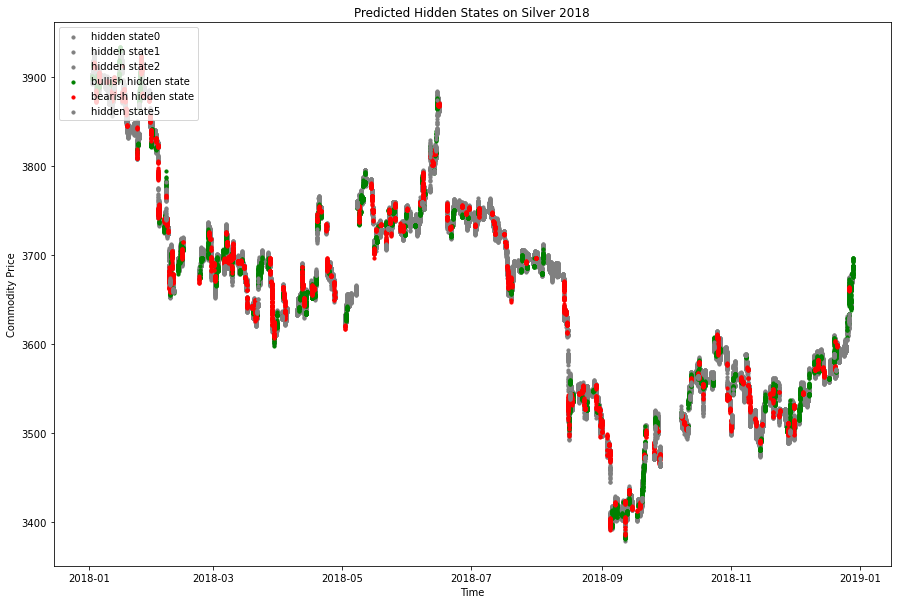

In [33]:
plot_hidden_states(df18,hidden_states18,6,'Predicted Hidden States on Silver 2018',states18[0],states18[1])

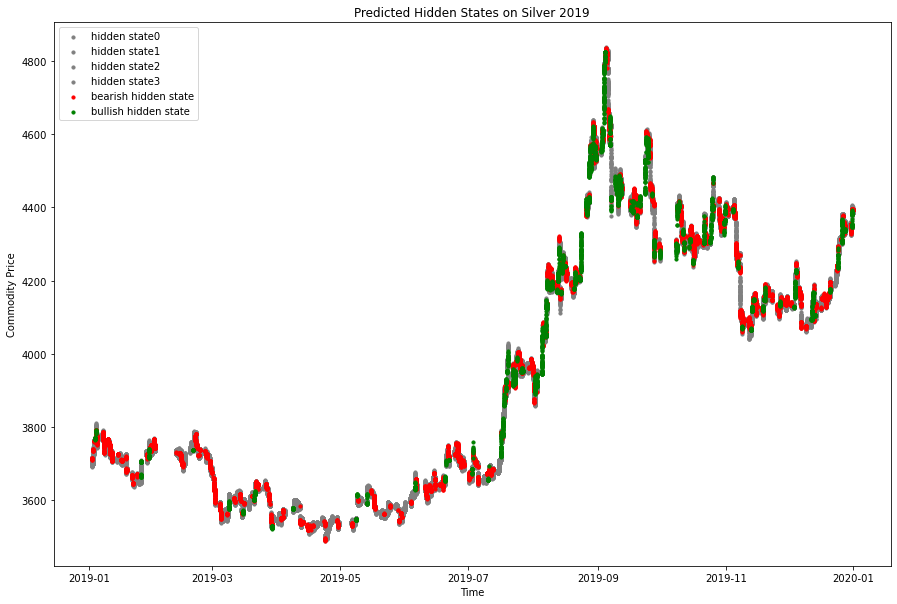

In [34]:
plot_hidden_states(df19,hidden_states19,6,'Predicted Hidden States on Silver 2019',states19[0],states19[1])

In [ ]:
df2019 = pd.read_csv('./data/2019/' + 'agm' + '.csv', index_col=0, encoding='gbk')


metals_2019['time'] = clean_df(df2019)['time'][60:-30]
metals_2019['silver'] = ag_returns[0]
# metals['silver_2020'] = ag_returns[1]
metals_2019['silver_acc'] = metals_2019['silver'].cumsum()
metals_2019.index = metals_2019['time']
metals_2019['silver_acc'].plot()

In [6]:

coms2019 =  pd.read_csv('./returns_data/commodity_returns_2019.csv')
coms2020 =  pd.read_csv('./returns_data/commodity_returns_2020.csv')

coms2019.index = coms2019['time']
coms2019 = coms2019.drop(['time'],axis = 1)

coms2020.index = coms2020['time']
coms2020 = coms2020.drop(['time'],axis = 1)


coms2019.columns = ['Silver 2019', 'Cotton 2019', 'Hot Rolled Steel 2019', 'Coal 2019',
       'Nickel 2019', 'Polypropylene 2019', 'Manganese Silicon Alloy 2019',
       'Aluminum 2019', 'Copper 2019', 'Iron Ore 2019', 'Polyethylene 2019',
       'Oil 2019', 'Deformed Steel Bar 2019', 'Tin 2019',
       'Polyvinyl Chloride 2019', 'Asphalt 2019', 'Ethylene Glycol 2019',
       'Coke 2019', 'Methanol 2019', 'Lead 2019', 'Rubber 2019', 'Sugar 2019',
       'Zinc 2019']

coms2020.columns = ['Silver 2020', 'Cotton 2020', 'Hot Rolled Steel 2020', 'Coal 2020',
       'Nickel 2020', 'Polypropylene 2020', 'Manganese Silicon Alloy 2020',
       'Aluminum 2020', 'Copper 2020', 'Iron Ore 2020', 'Polyethylene 2020',
       'Oil 2020', 'Deformed Steel Bar 2020', 'Tin 2020',
       'Polyvinyl Chloride 2020', 'Asphalt 2020', 'Ethylene Glycol 2020',
       'Coke 2020', 'Methanol 2020', 'Lead 2020', 'Rubber 2020', 'Sugar 2020',
       'Zinc 2020']

coms2019 = coms2019[['Silver 2019',  'Hot Rolled Steel 2019',  'Deformed Steel Bar 2019',
       'Nickel 2019',  'Lead 2019','Manganese Silicon Alloy 2019',
       'Aluminum 2019', 'Copper 2019', 'Iron Ore 2019',  'Tin 2019','Zinc 2019',
        'Coal 2019', 'Oil 2019',
        'Polyethylene 2019','Polyvinyl Chloride 2019','Polypropylene 2019', 'Asphalt 2019', 'Ethylene Glycol 2019',
       'Coke 2019', 'Methanol 2019',  'Sugar 2019','Rubber 2019','Cotton 2019']]

coms2020 = coms2020[['Silver 2020',  'Hot Rolled Steel 2020','Copper 2020','Nickel 2020',
       'Zinc 2020', 'Lead 2020', 'Manganese Silicon Alloy 2020','Aluminum 2020',  'Iron Ore 2020','Tin 2020', 
       'Coal 2020','Oil 2020', 
       'Polypropylene 2020','Polyethylene 2020', 'Polyvinyl Chloride 2020', 'Asphalt 2020', 'Ethylene Glycol 2020',
       'Coke 2020', 'Methanol 2020',  'Cotton 2020','Rubber 2020', 'Sugar 2020']]

metals = [('hcm','Hot Rolled Steel'),('agm','Silver'),('nim','Nickel'),
('smm',"Manganese Silicon Alloy"),('im','Iron Ore'),('rbm','Deformed Steel Bar'),
 ('snm','Tin'),('pbm',"Lead"),('znm','Zinc'),('alm','Aluminum'),('cum','Copper')]

agricultural = [('cfm','Cotton'),('srm',"Sugar"),('rum',"Rubber")]

chemicals = [('vm','Polyvinyl Chloride'),('ppm',"Polypropylene"),
             ('egm','Ethylene Glycol'),('mam',"Methanol"),('jm','Coke'),('lm','Polyethylene'),('bum','Asphalt')]

energy = [('oim','Oil'),('jmm','Coal')]

coms2019['All Strategies 2019'] = coms2019.sum(axis=1)
coms2020['All Strategies 2020'] = coms2020.sum(axis=1)

# Performance Analysis

In [7]:
def in_list(commodity,comtype):
    for i in comtype:
        if i[1] == commodity:
            return True
    return False
def select_color(commodity):
    
    commodity = commodity[:-5]
    if in_list(commodity,metals):
        return 'gray'
    elif in_list(commodity,agricultural):
        return 'green'
    elif in_list(commodity,chemicals):
        return 'blue'
    elif in_list(commodity,energy):
        return 'orange'
    else:
        return 'magenta'
    
def plot_histograms(df):
    fig, axs = plt.subplots(6, 4, figsize=(20,35))

    j=0
    for row in range(0,6):
        for col in range(0,4):
            if(j < len(df.columns)):
                series = df.loc[ (df[df.columns[j]] !=0) & ~(df[df.columns[j]].isna())][df.columns[j]]

                axs[row][col].hist(x=series, bins=20, color= select_color(df.columns[j]))
                axs[row][col].axvline(x=0, color='r', linestyle='--')
                axs[row][col].title.set_text('Histogram of Returns for ' + str(df.columns[j]))
                axs[row][col].annotate('$\mu$ = ' + str(round(np.mean(series),5)) + '\n$\sigma$ = ' +
                        str(round(np.std(series),3)) +\
                                   '\nKurtosis = ' + str(round(series.kurtosis(),3)) +\
                                    '\nSharpe = ' + str(round(np.mean(series) / np.std(series), 3)), xy=(.5, .7), xycoords='axes fraction')
                axs[row][col].set_xlabel('Return')
                axs[row][col].set_ylabel('Frequency')

                j+=1
                plt.tight_layout()

            else:
                axs[row][col].set_visible(False)
                
def plot_qq_plots(df):
    fig, axs = plt.subplots(6, 4, figsize=(20,35))
    count = 0
    for k, ax in zip(df.columns, np.ravel(axs)):
        if(count < len(df.columns)):
            series = df.loc[(df[k] !=0) & ~(df[k].isna())][k]

            smapi.qqplot(series, line='45', ax=ax,fit = True, color = select_color(k))
            ax.annotate( 'Sharpe = ' + str(round(np.mean(series) / np.std(series), 3))  +\
                                   '\nKurtosis = ' + str(round(series.kurtosis(),3)) +\
                                    '\nSkew = ' +  str(round(series.skew(),3)), xy=(.1, .8), xycoords='axes fraction')
                        
            ax.set_title(f'{k} QQ Plot')
            count = count + 1
            plt.tight_layout()
            

def plot_pnl(df):
    fig, axs = plt.subplots(6, 4, figsize=(20,35))
    for k, ax in zip(df.columns, np.ravel(axs)):
        temp = df[k].dropna()
        ax.plot(pd.to_datetime(temp.index),temp.cumsum(),color = select_color(k))
        ax.set_title(f'{k} PnL')
        ax.set_ylabel('PnL')
        ax.set_xlabel('Time')

        plt.tight_layout()
    fig.autofmt_xdate()

 


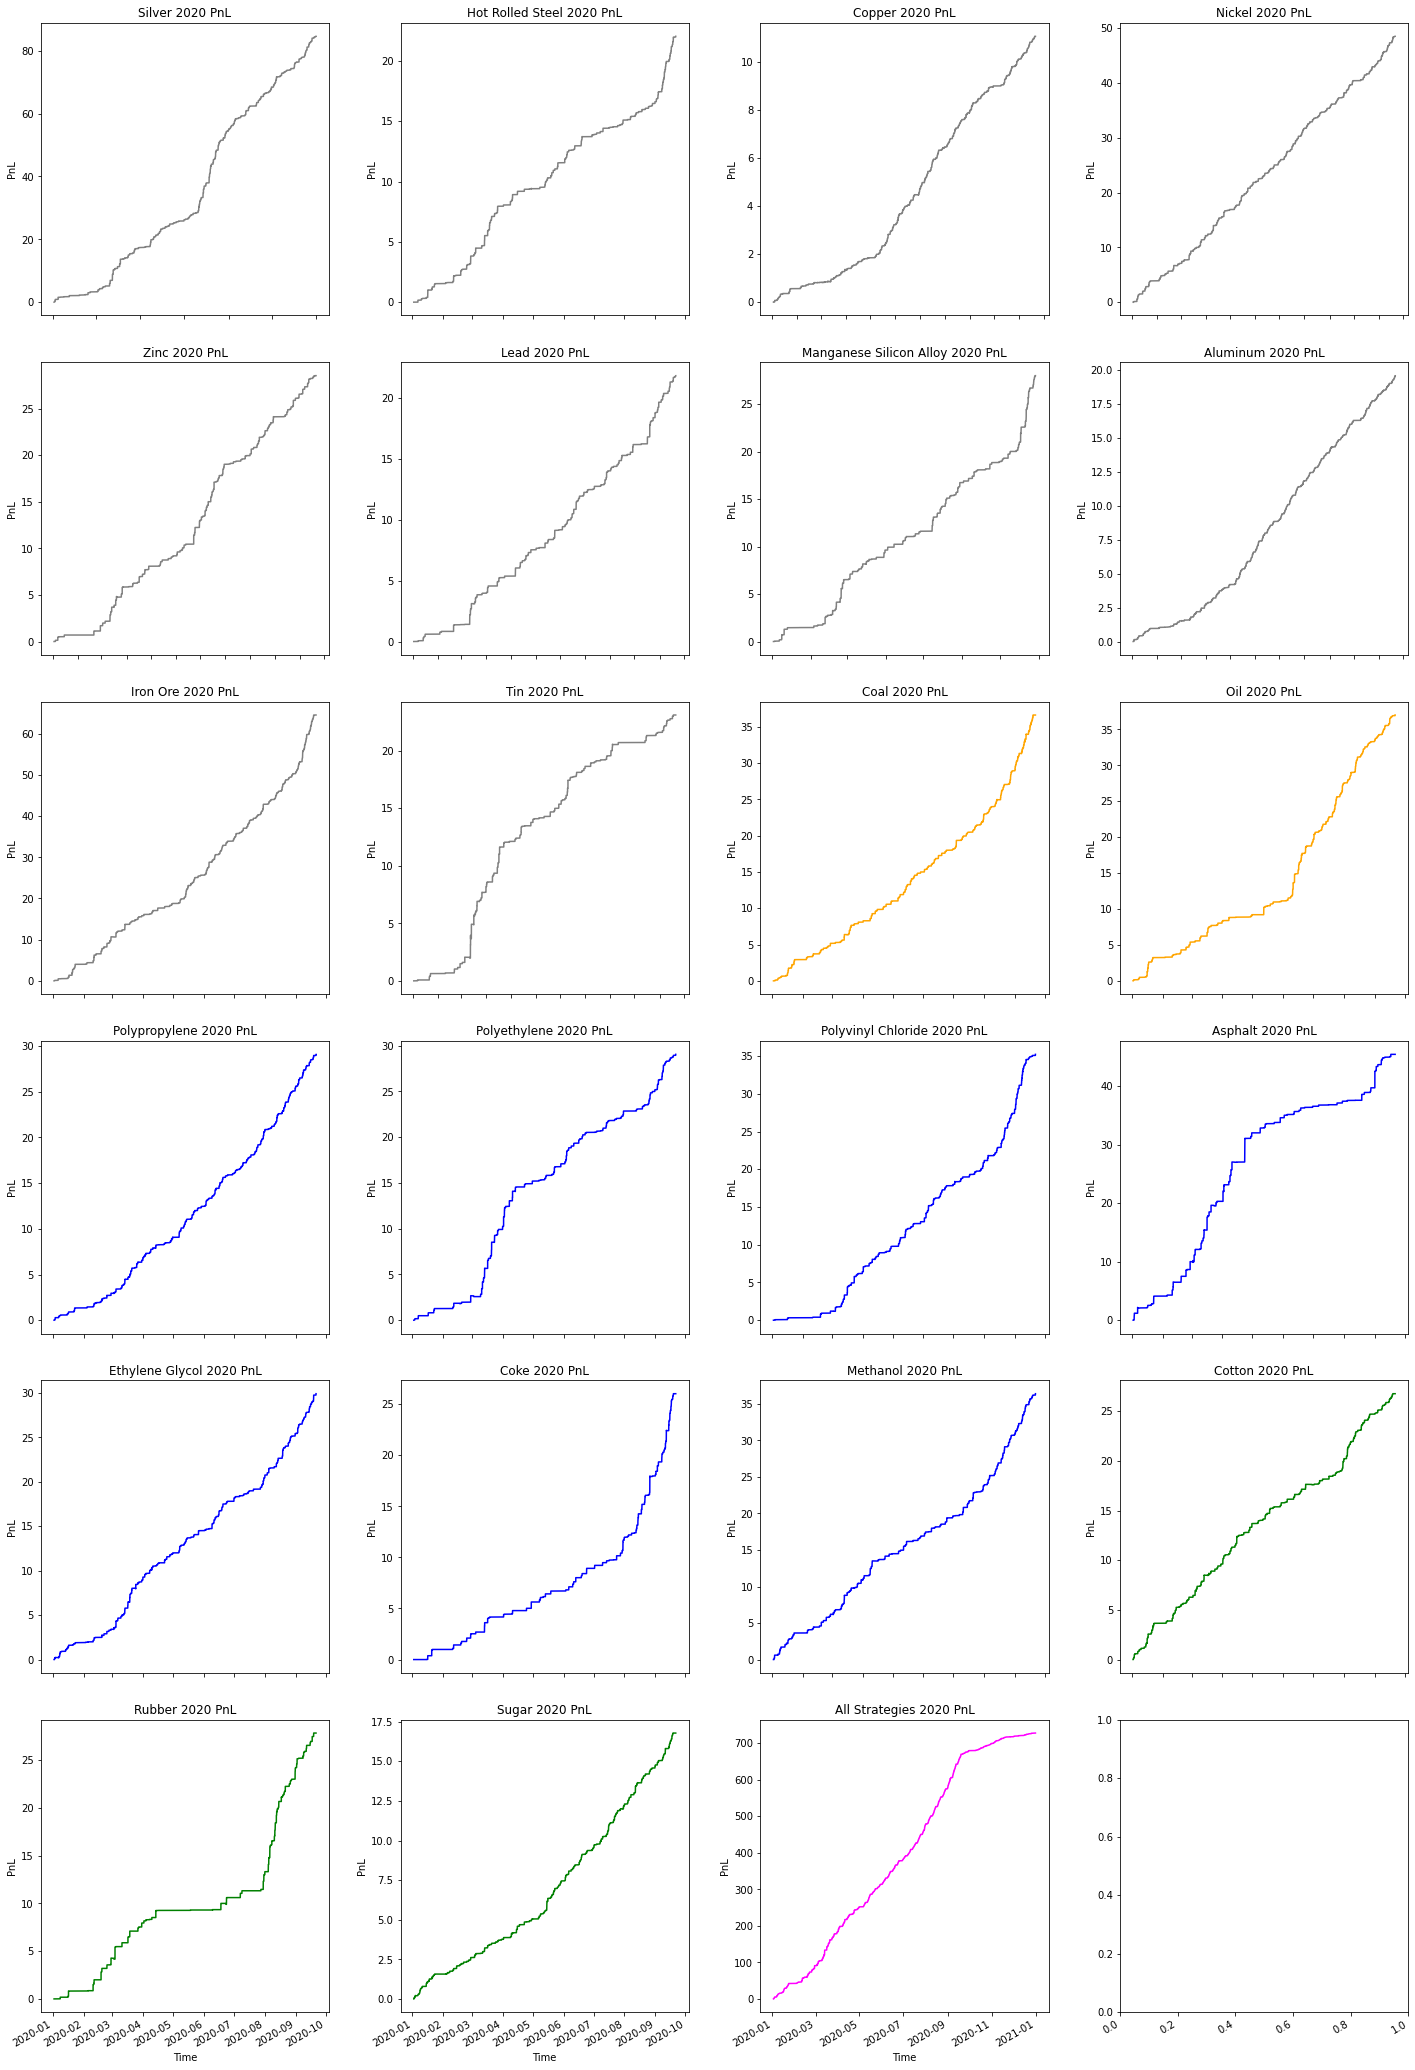

In [8]:
plot_pnl(coms2020)

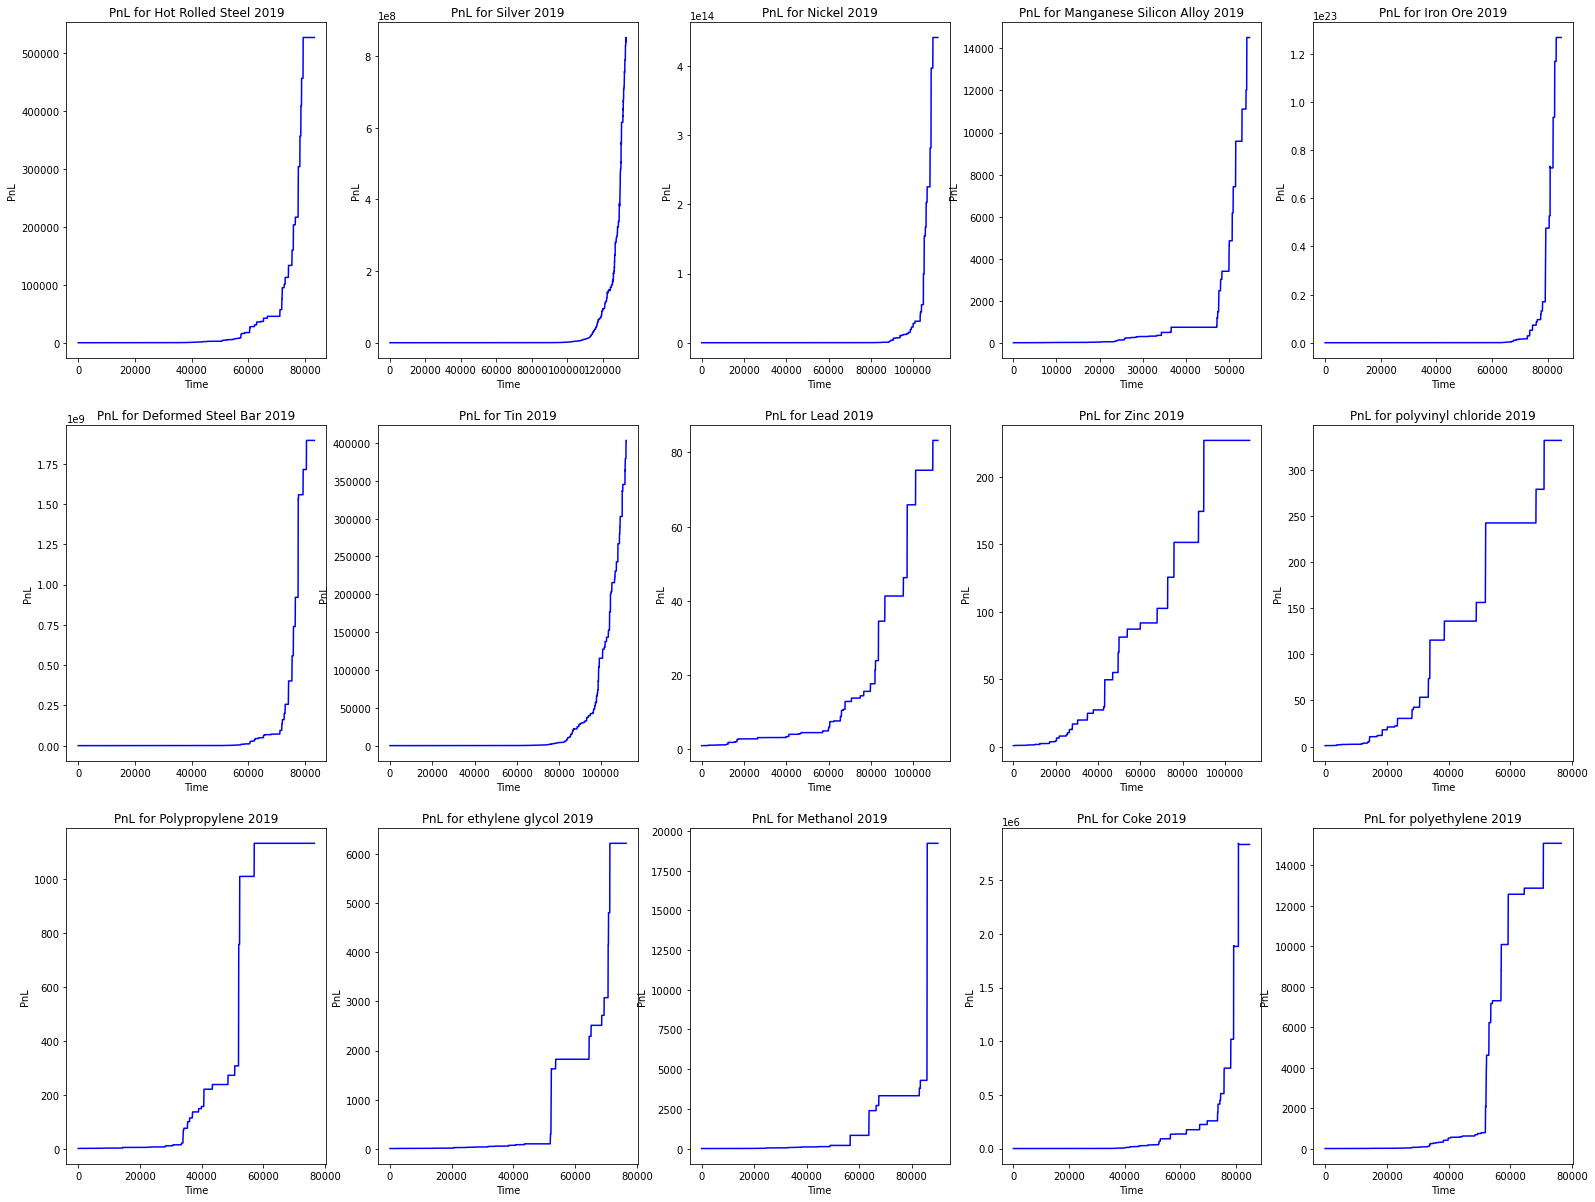

In [ ]:
fig, axs = plt.subplots(3, 5, figsize=(27,21))

j=0
colors = ['b', 'b', 'b', 'b', 'b']

for row in range(0,3):
    for col in range(0,5):
        axs[row][col].plot((coms2020[coms2020.columns[j]]+1).cumsum(), color=colors[col])
        axs[row][col].title.set_text('PnL for ' + str(coms2020.columns[j]))
        axs[row][col].set_xlabel('Time')
        axs[row][col].set_ylabel('PnL')
        j+=1

Text(0, 0.5, 'PnL')

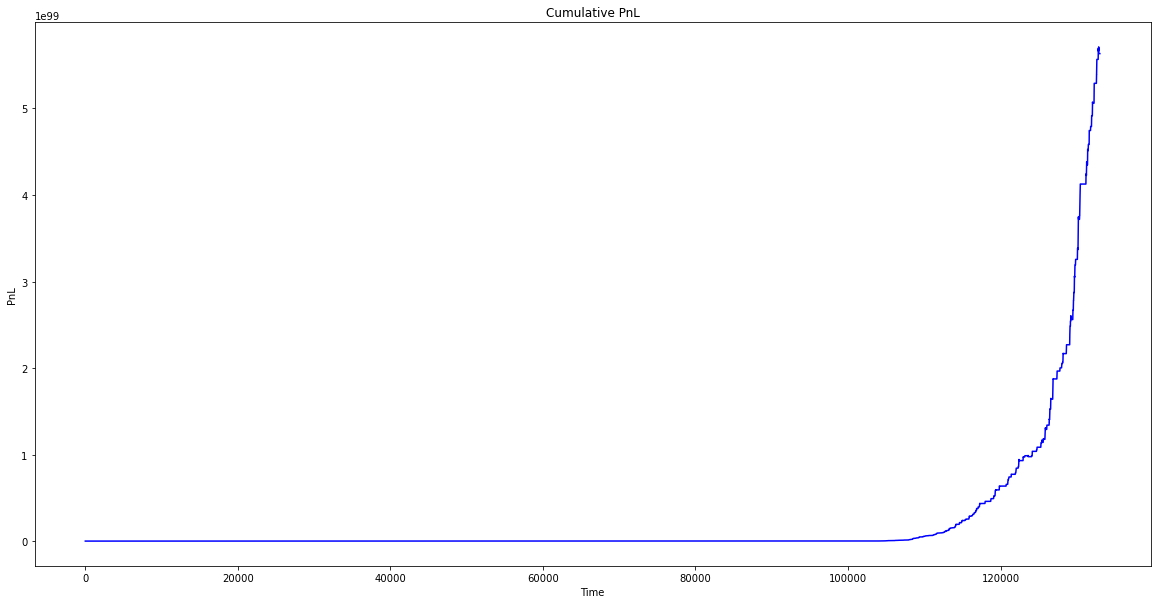

In [141]:
plt.figure(figsize=(20,10))
plt.plot((metals2019['netret']+1).cumprod(), color=colors[col])
plt.title('Cumulative PnL')
plt.xlabel('Time')
plt.ylabel('PnL')

In [120]:
coms2019 = coms2019.dropna()
coms2019['netret'] = coms2019.sum(axis=1)

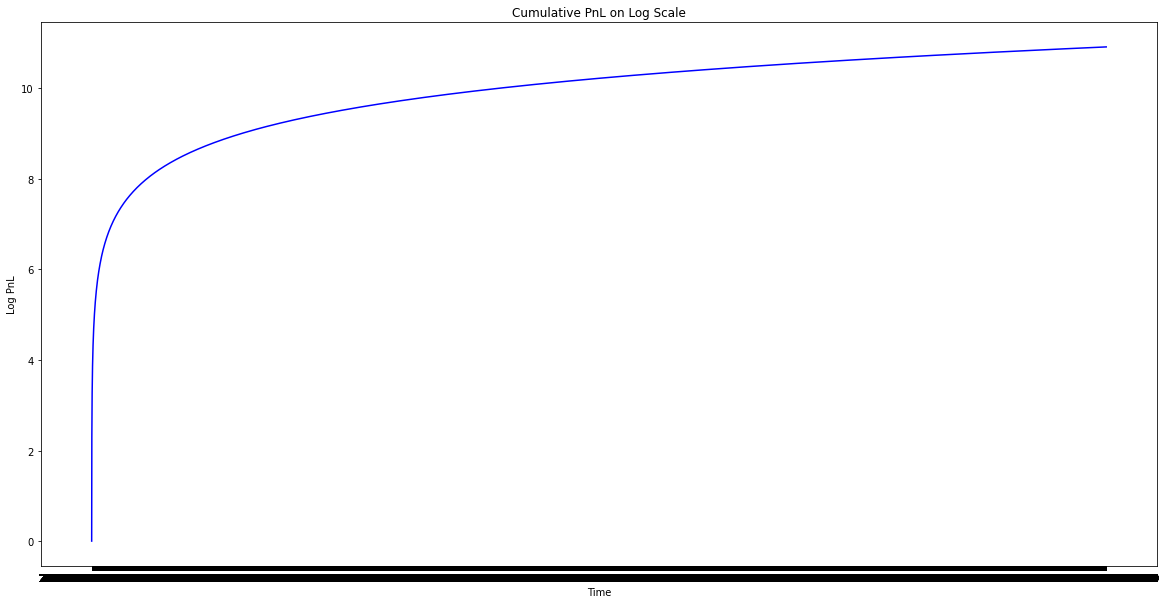

In [121]:
plt.figure(figsize=(20,10))
plt.plot(np.log( (coms2019['netret']+1).cumsum() ), color=colors[col])
plt.title('Cumulative PnL on Log Scale')
plt.xlabel('Time')
plt.ylabel('Log PnL')
plt.show()

Text(0, 0.5, 'Frequency')

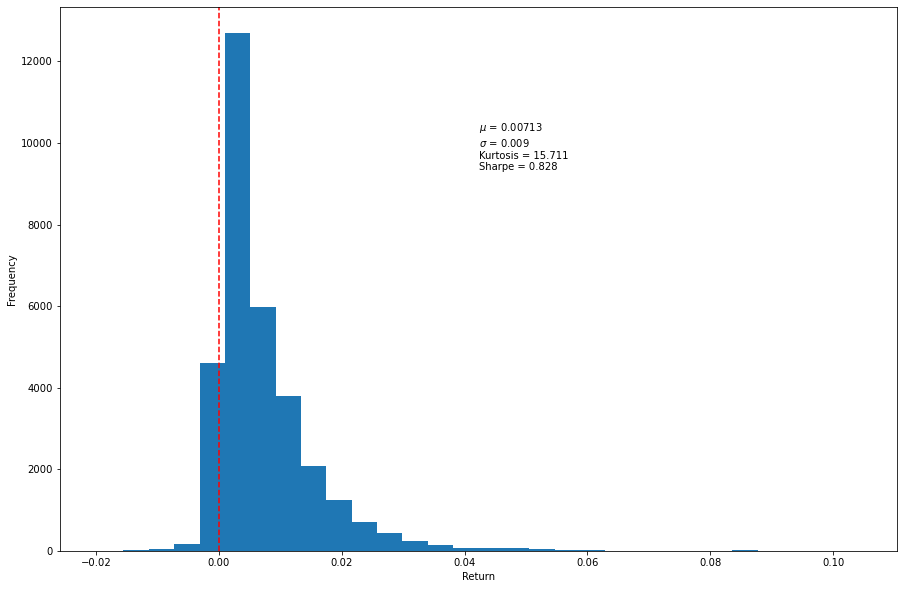

In [143]:
plt.figure(figsize=(15,10))

series = metals2019['netret'].loc[ (metals2019['netret'] != 0) & ~(metals2019['netret'].isna())]

plt.hist(series, bins=30)
plt.axvline(x=0, color='r', linestyle='--')
plt.annotate('$\mu$ = ' + str(round(np.mean(series),5)) + '\n$\sigma$ = ' +
                str(round(np.std(series),3)) +\
                           '\nKurtosis = ' + str(round(series.kurtosis(),3)) +\
                            '\nSharpe = ' + str(round(np.mean(series) / np.std(series), 3)), 
             xy=(.5, .7), xycoords='axes fraction')
plt.xlabel('Return')
plt.ylabel('Frequency')

In [145]:
df2018 = pd.read_csv('./data/2018/' + commodity + '.csv', index_col=0, encoding='gbk')
df2019 = pd.read_csv('./data/2019/' + commodity + '.csv', index_col=0, encoding='gbk')
df2020 = pd.read_csv('./data/2020/' + commodity + '.csv', index_col=0, encoding='gbk')
df18 = prepare_data(clean_df(df2018))
df19 = prepare_data(clean_df(df2019))
df20 = prepare_data(clean_df(df2020))

NameError: name 'commodity' is not defined

In [148]:
for metal in metals:
    print(metal)

('hcm', 'Hot Rolled Steel')
('agm', 'Silver')
('nim', 'Nickel')
('smm', 'Manganese Silicon Alloy')
('im', 'Iron Ore')
('rbm', 'Deformed Steel Bar')
('snm', 'Tin')
('pbm', 'Lead')
('znm', 'Zinc')


In [154]:
df2018 = pd.read_csv('C:\\Users\\nfischer\\Desktop\\Chinese CTA Data\\2018\\' + 'agm' + '.csv', index_col=0, encoding='gbk')
df18 = prepare_data(clean_df(df2018))

In [205]:
test['close'] = df18.resample('D', on='time').last()
test['close'] = test['close'].pct_change()
#x['monthly_return'] = x.resample('M').last()['prices'].pct_change(1).shift(-1)

In [206]:
test

,close,volume,log_close,time,lr_5min,lr_30min,fast_ma,slow_ma,macd
time,,,,,,,,,
2018-01-02,NaN,50.0,8.272060,2018-01-02 23:59:00,0.000000,0.000000,3912.697915,3912.682787,0.015128
2018-01-03,-0.001278,94.0,8.270781,2018-01-03 23:59:00,0.000102,0.000051,3907.005653,3906.191557,0.814096
2018-01-04,0.000000,962.0,8.270781,2018-01-04 23:59:00,0.000102,0.000085,3905.479471,3902.449509,3.029962
2018-01-05,-0.003327,466.0,8.267449,2018-01-05 23:59:00,0.000103,-0.000009,3894.091424,3894.326034,-0.234611
2018-01-06,0.002311,800.0,8.269757,2018-01-06 02:30:00,0.000102,0.000017,3903.097382,3902.655160,0.442222
...,...,...,...,...,...,...,...,...,...
2018-12-24,0.003626,36.0,8.188133,2018-12-24 23:59:00,0.000000,-0.000019,3598.678923,3598.987971,-0.309047
2018-12-25,0.003891,26.0,8.192017,2018-12-25 23:59:00,-0.000111,-0.000018,3613.574539,3614.158614,-0.584075
2018-12-26,0.014120,1350.0,8.206038,2018-12-26 23:59:00,0.000000,0.000055,3662.689174,3658.786121,3.903053


In [180]:
df18.iloc[374+555:374+2*555]

,close,volume,log_close,time,lr_5min,lr_30min,fast_ma,slow_ma,macd
959,3907.0,34.0,8.270525,2018-01-04 00:00:00,0.000051,0.000043,3907.004921,3906.228065,0.776856
960,3908.0,124.0,8.270781,2018-01-04 00:01:00,0.000051,0.000043,3907.133733,3906.308082,0.825651
961,3908.0,206.0,8.270781,2018-01-04 00:02:00,0.000051,0.000043,3907.245871,3906.384487,0.861385
962,3907.0,4.0,8.270525,2018-01-04 00:03:00,0.000000,0.000026,3907.214043,3906.412282,0.801761
963,3907.0,354.0,8.270525,2018-01-04 00:04:00,-0.000051,0.000026,3907.186335,3906.438823,0.747513
...,...,...,...,...,...,...,...,...,...
1509,3907.0,960.0,8.270525,2018-01-04 23:55:00,0.000205,0.000068,3903.807713,3901.374494,2.433219
1510,3908.0,2178.0,8.270781,2018-01-04 23:56:00,0.000256,0.000077,3904.350402,3901.673691,2.676711
1511,3908.0,2432.0,8.270781,2018-01-04 23:57:00,0.000205,0.000085,3904.822841,3901.959377,2.863464
1512,3907.0,2102.0,8.270525,2018-01-04 23:58:00,0.000051,0.000077,3905.104673,3902.187003,2.917669



$\sigma$
